
**Ensembe Pipeline**

This work of mine implements the end-to-end pipeline for training and evaluating
a suite of high-performance CNNs and their ensembles for cervical cancer classification.

Stuff I am implementing

1.  Pre-caching of model weights to ensure stable execution in cloud environments.
2.  Data loading and stratified splitting of the combined Herlev and Sipakmed datasets.
3.  An advanced data augmentation and preprocessing pipeline with options for grayscale and enhanced color processing.
4.  Hyperparameter optimization using KerasTuner (with an option to use pre-computed values).
5.  A two-stage training protocol (feature extraction followed by fine-tuning) for six state-of-the-art CNN architectures.
6.  Construction and training of both Averaging and Stacking ensembles.
7.  A comprehensive final evaluation on held-out test sets from both original datasets to measure model generalization.


In [1]:
# ==============================================================================
# ENVIRONMENT SETUP AND DEPENDENCIES
# ==============================================================================

!pip install keras-tuner -q
import tensorflow as tf
from tensorflow.keras.applications import (
    VGG16, EfficientNetB2, Xception, InceptionResNetV2, DenseNet201, NASNetMobile
)
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import (
    Input, Dense, GlobalAveragePooling2D, Dropout, Concatenate, Average,
    RandomFlip, RandomRotation, RandomZoom, RandomContrast, GaussianNoise,
    RandomBrightness
)
from tensorflow.keras.optimizers import Nadam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import keras_tuner as kt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import glob
import os
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import class_weight
from google.colab import drive

# Mount Google Drive to access project files
# I fetch data from there
drive.mount('/content/drive')

# harddrive check
print("TensorFlow Version:", tf.__version__)
if tf.config.list_physical_devices('GPU'):
    print("GPU is available.")
else:
    print("GPU not available. Training will be significantly slower.")
# ==============================================================================

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 13.1 MB/s eta 0:00:00
Mounted at /content/drive
TensorFlow Version: 2.18.0
GPU is available.


In [2]:
# ==============================================================================
# GLOBAL CONFIGURATION
# ==============================================================================

# --- Path Configuration ---
# The datasets previously downloaded from Kaggle are kept here.
# This should point to the directory containing your 'HerlevData' and 'im_*' folders.
GDRIVE_PROJECT_PATH = Path('/content/drive/MyDrive/pap_project/data/raw/')
MODELS_SAVE_PATH = Path('/content/drive/MyDrive/pap_project/final_models/')
TUNER_DIR = 'kerastuner_dir'
TUNER_PROJECT_NAME = 'cervical_cancer_tuning'

# ensure there exist the path
MODELS_SAVE_PATH.mkdir(parents=True, exist_ok=True)

# --- Model & Training Configuration ---
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
INITIAL_TRAIN_EPOCHS = 25
FINETUNE_EPOCHS = 20
ENSEMBLE_TRAIN_EPOCHS = 30
SEED = 42

# --- Label Mapping ---
LABEL_MAP = {'normal': 0, 'abnormal': 1}
CLASS_NAMES = ['Normal', 'Abnormal']
# ==============================================================================

In [3]:
# ==============================================================================
# DATA LOADING AND SPLITTING
# ==============================================================================

def find_image_paths_by_type(data_path, label_map):
    """
    Recursively finds image paths and assigns binary labels based on parent folder names.
    """

    image_paths, labels = [], []
    for ext in ['*.bmp', '*.BMP']: # our datasets sometimes use capital extension
        for file in data_path.rglob(ext):
            parent_folder = file.parent.name.lower()
            if 'carcinoma' in parent_folder or 'dysplastic' in parent_folder:
                labels.append('abnormal')
                image_paths.append(str(file))
            elif 'normal' in parent_folder:
                labels.append('normal')
                image_paths.append(str(file))
    df = pd.DataFrame({'filepath': image_paths, 'label': labels})
    if not df.empty:
        df['label_id'] = df['label'].map(label_map).astype(int)
    return df

def load_all_data_and_prepare_splits():
    """
    Loads both Herlev and Sipakmed datasets, then performs stratified splits.
    Returns the combined training, validation, and test sets.
    Assumes that Herlev comes in a train / test split form.
    """

    print("--- Loading Herlev Dataset (using pre-split folders) ---")
    herlev_train_path = GDRIVE_PROJECT_PATH / 'HerlevData' / 'train'
    herlev_test_path = GDRIVE_PROJECT_PATH / 'HerlevData' / 'test'
    herlev_train_df = find_image_paths_by_type(herlev_train_path, LABEL_MAP)
    herlev_test_df = find_image_paths_by_type(herlev_test_path, LABEL_MAP)
    print(f"Loaded {len(herlev_train_df)} Herlev training images and {len(herlev_test_df)} testing images.")

    print("\n--- Loading and Splitting Sipakmed Dataset ---")
    # This glob pattern specifically targets the individual cropped cell images.
    sipakmed_paths = glob.glob(str(GDRIVE_PROJECT_PATH / 'im_*' / '*' / 'CROPPED' / '*.bmp'))
    sipakmed_labels = ['normal' if 'im_Parabasal' in p or 'im_Superficial-Intermediate' in p else 'abnormal' for p in sipakmed_paths]
    sipakmed_full_df = pd.DataFrame({'filepath': sipakmed_paths, 'label': sipakmed_labels})
    sipakmed_full_df['label_id'] = sipakmed_full_df['label'].map(LABEL_MAP).astype(int)
    print(f"Loaded {len(sipakmed_full_df)} total Sipakmed images.")

    # 70% train, 15% validation, 15% test.
    sip_train_val_df, sip_test_df = train_test_split(sipakmed_full_df, test_size=0.15, random_state=SEED, stratify=sipakmed_full_df['label_id'])
    sip_train_df, sip_val_df = train_test_split(sip_train_val_df, test_size=0.1765, random_state=SEED, stratify=sip_train_val_df['label_id']) # 0.15 / 0.85 = 0.1765

    print("\n--- Combining Data ---")
    final_train_df = pd.concat([herlev_train_df, sip_train_df], ignore_index=True).sample(frac=1, random_state=SEED).reset_index(drop=True)

    print(f"\nFinal Combined Training Set: {len(final_train_df)} images")
    print(f"Final Validation Set (Sipakmed only): {len(sip_val_df)} images")
    print(f"Final Herlev Test Set: {len(herlev_test_df)} images")
    print(f"Final Sipakmed Test Set: {len(sip_test_df)} images")
    return final_train_df, sip_val_df, herlev_test_df, sip_test_df

# Execute data loading and splitting
train_df, val_df, herlev_test_df, sipakmed_test_df = load_all_data_and_prepare_splits()

# Calculate class weights to counteract data imbalance during training.
# This gives more importance to the minority class.
class_weights = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(train_df['label_id']),
    y=train_df['label_id'].values
)
class_weight_dict = dict(enumerate(class_weights))
print(f"\nCalculated Class Weights for Training: {class_weight_dict}")
# ==============================================================================

--- Loading Herlev Dataset (using pre-split folders) ---
Loaded 643 Herlev training images and 274 testing images.

--- Loading and Splitting Sipakmed Dataset ---
Loaded 4049 total Sipakmed images.

--- Combining Data ---

Final Combined Training Set: 3476 images
Final Validation Set (Sipakmed only): 608 images
Final Herlev Test Set: 274 images
Final Sipakmed Test Set: 608 images

Calculated Class Weights for Training: {0: np.float64(1.3358954650269024), 1: np.float64(0.799080459770115)}


In [4]:
# ==============================================================================
# DATA PIPELINE (PREPROCESSING & AUGMENTATION)
# ==============================================================================

def apply_color_preprocessing(image):
    """
    Applies a sequence of advanced color and contrast enhancements.
    - Bilateral Filter: Reduces noise while preserving critical cell edges.
    - CLAHE: Enhances local contrast to reveal subtle texture in the nucleus and cytoplasm.
    """

    img_np = image.numpy().astype(np.uint8)
    img_filtered = cv2.bilateralFilter(img_np, d=9, sigmaColor=75, sigmaSpace=75)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    lab = cv2.cvtColor(img_filtered, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)
    l_clahe = clahe.apply(l)
    lab_clahe = cv2.merge((l_clahe, a, b))
    img_enhanced = cv2.cvtColor(lab_clahe, cv2.COLOR_LAB2RGB)
    return tf.convert_to_tensor(img_enhanced, dtype=tf.float32)

@tf.function
def tf_color_preprocessing_wrapper(image, label):
    """Wraps the OpenCV function in a tf.py_function for TensorFlow graph compatibility."""

    image, = tf.py_function(lambda img: [apply_color_preprocessing(img)], [image], [tf.float32])
    image.set_shape([*IMG_SIZE, 3])
    return image, label

# Define the data augmentation pipeline using Keras layers.
# These operations are applied on-the-fly during training to increase data variance.
data_augmentation_layer = tf.keras.Sequential([
    RandomFlip("horizontal_and_vertical"),
    RandomRotation(0.5),
    RandomZoom(0.3),
    RandomContrast(0.4),
    RandomBrightness(factor=0.3),
    GaussianNoise(stddev=0.1)
], name="data_augmentation")

def load_and_resize(filepath, label):
    """Loads a .bmp image from a filepath and resizes it to the target size."""

    img = tf.io.read_file(filepath)
    img = tf.io.decode_bmp(img, channels=3)
    img = tf.image.resize(img, IMG_SIZE)
    return img, label


def create_dataset(df, shuffle=False, augment=False, batch_size=BATCH_SIZE, preprocess_fn=None, is_grayscale=False, use_color_pp=False):
    """
    Constructs a complete, optimized tf.data.Dataset pipeline from a pandas DataFrame.
    """

    dataset = tf.data.Dataset.from_tensor_slices((df['filepath'].values, df['label_id'].values))
    dataset = dataset.map(load_and_resize, num_parallel_calls=tf.data.AUTOTUNE)

    # Color processing if enabled
    if use_color_pp:
        dataset = dataset.map(tf_color_preprocessing_wrapper, num_parallel_calls=tf.data.AUTOTUNE)

    # Convert to grayscale if specified
    # !!! Must be converted back to 3 channels for pre-trained models !!!!!
    if is_grayscale:
        dataset = dataset.map(lambda x, y: (tf.image.rgb_to_grayscale(x), y), num_parallel_calls=tf.data.AUTOTUNE)
        dataset = dataset.map(lambda x, y: (tf.image.grayscale_to_rgb(x), y), num_parallel_calls=tf.data.AUTOTUNE)

    # Apply on the fly data augmentation if this is a training dataset
    if augment:
        dataset = dataset.map(lambda x, y: (data_augmentation_layer(x, training=True), y), num_parallel_calls=tf.data.AUTOTUNE)

    # Shuffle the dataset if enabledd
    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(df), seed=SEED)

    # Batch the data
    dataset = dataset.batch(batch_size)

    # Apply the model-specific preprocessing function (e.g., scaling pixel values to [-1, 1])
    if preprocess_fn:
        dataset = dataset.map(lambda x, y: (preprocess_fn(x), y), num_parallel_calls=tf.data.AUTOTUNE)

    # Prefetch data to optimize GPU utilization
    return dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

# ==============================================================================

In [5]:
# ==============================================================================
# HYPERPARAMETER TUNING (WITH SKIP-LOGIC)
# ==============================================================================

# If you have the optimal parameters just skip it
SKIP_TUNING = True

if not SKIP_TUNING:
    def build_for_tuning(hp):
        """
        Builds a model with hyperparameters for the tuner to optimize.
        Uses EfficentNetB2 as the base model.
        """

        hp_learning_rate = hp.Choice('learning_rate', values=[1e-3, 1e-4, 1e-5])
        hp_dropout_rate = hp.Float('dropout_rate', min_value=0.2, max_value=0.5, step=0.1)
        hp_dense_units = hp.Int('dense_units', min_value=128, max_value=512, step=128)

        base_model = EfficientNetB2(include_top=False, weights='imagenet', input_shape=IMG_SIZE + (3,))
        base_model.trainable = False

        inputs = Input(shape=IMG_SIZE + (3,))
        x = base_model(inputs, training=False)
        x = GlobalAveragePooling2D()(x)
        x = Dropout(hp_dropout_rate)(x)
        x = Dense(units=hp_dense_units, activation='relu')(x)
        outputs = Dense(1, activation='sigmoid')(x)

        model = Model(inputs, outputs)
        model.compile(optimizer=Nadam(learning_rate=hp_learning_rate), loss=BinaryCrossentropy(), metrics=['accuracy'])
        return model

    tuner = kt.Hyperband(
        build_for_tuning,
        objective='val_accuracy',
        max_epochs=10,
        factor=3,
        directory=TUNER_DIR,
        project_name=TUNER_PROJECT_NAME,
        overwrite=True
    )

    print("--- Starting hyperparameter search... ---")
    tuner_train_ds = create_dataset(train_df, shuffle=True, augment=True, is_grayscale=True, preprocess_fn=tf.keras.applications.efficientnet.preprocess_input)
    tuner_val_ds = create_dataset(val_df, is_grayscale=True, preprocess_fn=tf.keras.applications.efficientnet.preprocess_input)
    tuner.search(tuner_train_ds, epochs=10, validation_data=tuner_val_ds, class_weight=class_weight_dict, callbacks=[EarlyStopping(monitor='val_loss', patience=3)])

    best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
    OPTIMAL_LR = best_hps.get('learning_rate')
    OPTIMAL_DROPOUT = best_hps.get('dropout_rate')
    OPTIMAL_DENSE_UNITS = best_hps.get('dense_units')
else:
    print("--- Skipping hyperparameter tuning and using pre-computed optimal values. ---")
    OPTIMAL_LR = 0.001          # my tests resulted in those optimal params
    OPTIMAL_DROPOUT = 0.30
    OPTIMAL_DENSE_UNITS = 512

print("\n--- Optimal Hyperparameters ---")
print(f"  - Learning Rate: {OPTIMAL_LR}")
print(f"  - Dropout Rate: {OPTIMAL_DROPOUT:.2f}")
print(f"  - Dense Units: {OPTIMAL_DENSE_UNITS}")
# ==============================================================================

--- Skipping hyperparameter tuning and using pre-computed optimal values. ---

--- Optimal Hyperparameters ---
  - Learning Rate: 0.001
  - Dropout Rate: 0.30
  - Dense Units: 512


In [6]:
# ==============================================================================
# PRE-CACHE MODEL WEIGHTS TO PREVENT DOWNLOAD ERRORS
# ==============================================================================

# This block manually downloads the required pre-trained weights using wget.
# This is a robust workaround for potential "403 Forbidden" or other network
# errors that can occur when Keras attempts to download weights automatically.
# Keras will find these files in its cache and skip the download step during model creation.


# Define the Keras cache directory where weights are stored
keras_cache_dir = os.path.join(os.path.expanduser('~'), '.keras', 'models')
os.makedirs(keras_cache_dir, exist_ok=True)
print(f"Keras model cache directory is: {keras_cache_dir}")

# A dictionary containing the URLs and correct filenames for the required model weights
weights_to_download = {
    'VGG16': {
        "url": "https://storage.googleapis.com/tensorflow/keras-applications/vgg16/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5",
        "filename": "vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5"
    },
    'Xception': {
        "url": "https://storage.googleapis.com/tensorflow/keras-applications/xception/xception_weights_tf_dim_ordering_tf_kernels_notop.h5",
        "filename": "xception_weights_tf_dim_ordering_tf_kernels_notop.h5"
    },
    'EfficientNetB2': {
        "url": "https://storage.googleapis.com/keras-applications/efficientnetb2_notop.h5",
        "filename": "efficientnetb2_notop.h5"
    },
    'InceptionResNetV2': {
        "url": "https://storage.googleapis.com/tensorflow/keras-applications/inception_resnet_v2/inception_resnet_v2_weights_tf_dim_ordering_tf_kernels_notop.h5",
        "filename": "inception_resnet_v2_weights_tf_dim_ordering_tf_kernels_notop.h5"
    },
    'DenseNet201': {
        "url": "https://storage.googleapis.com/tensorflow/keras-applications/densenet/densenet201_weights_tf_dim_ordering_tf_kernels_notop.h5",
        "filename": "densenet201_weights_tf_dim_ordering_tf_kernels_notop.h5"
    },
    'NASNetMobile': {
        "url": "https://storage.googleapis.com/tensorflow/keras-applications/nasnet/NASNet-mobile-no-top.h5",
        "filename": "NASNet-mobile-no-top.h5"
    }
}

# Loop through each model and download the weights if they don't exist or are corrupted
for model_name, details in weights_to_download.items():
    dest_path = os.path.join(keras_cache_dir, details['filename'])

    # check against corrupted or non existent files
    if not os.path.exists(dest_path) or os.path.getsize(dest_path) < 1000000:
        print(f"-> Downloading {model_name} weights...")
        !wget -q {details['url']} -O {dest_path}

        if os.path.exists(dest_path) and os.path.getsize(dest_path) > 1000000:
             print(f"   Saved to {dest_path}")
        else:
            print(f"   ERROR: Download failed for {model_name}. The file is missing or corrupt.")
            # raise RuntimeError(f"Download failed for {model_name}")
    else:
        print(f"-> Weights for {model_name} already exist and are valid. Skipping download.")

print("\n--- All model weights are cached. Proceeding to training pipeline. ---")
# ==============================================================================

Keras model cache directory is: /root/.keras/models
-> Downloading VGG16 weights...
   Saved to /root/.keras/models/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5
-> Downloading Xception weights...
   Saved to /root/.keras/models/xception_weights_tf_dim_ordering_tf_kernels_notop.h5
-> Downloading EfficientNetB2 weights...
   Saved to /root/.keras/models/efficientnetb2_notop.h5
-> Downloading InceptionResNetV2 weights...
   Saved to /root/.keras/models/inception_resnet_v2_weights_tf_dim_ordering_tf_kernels_notop.h5
-> Downloading DenseNet201 weights...
   Saved to /root/.keras/models/densenet201_weights_tf_dim_ordering_tf_kernels_notop.h5
-> Downloading NASNetMobile weights...
   Saved to /root/.keras/models/NASNet-mobile-no-top.h5

--- All model weights are cached. Proceeding to training pipeline. ---


In [7]:
# ==============================================================================
# FETCH PRE-TRAINED MODELS FROM GOOGLE DRIVE
# ==============================================================================
# If you already have trained the models just get them again instead of training again

# Models (on my previous run) were saved in this directory
MODELS_CHECK_PATH = Path('/content/drive/MyDrive/pap_project/final_models/')

print(f"Checking for existing models in: {MODELS_CHECK_PATH}")

if not MODELS_CHECK_PATH.exists():
    print("\nWARNING: The model directory does not exist.")
    print("The training pipeline will run from scratch and create this folder.")
else:
    # Find all '.keras' files in the directory.
    existing_models = list(MODELS_CHECK_PATH.glob('*.keras'))

    if not existing_models:
        print("\nNo pre-trained models found in the directory.")
        print("The training pipeline will run from scratch.")
    else:
        print(f"\nSUCCESS: Found {len(existing_models)} existing models. The training pipeline will skip these:")
        for model_path in existing_models:
            print(f"  - Found: {model_path.name}")
# ==============================================================================

Checking for existing models in: /content/drive/MyDrive/pap_project/final_models

SUCCESS: Found 28 existing models. The training pipeline will skip these:
  - Found: Xception_Color_best.keras
  - Found: VGG16_Grayscale_best.keras
  - Found: NASNetMobile_Grayscale_best_finetuned.keras
  - Found: Stacking_Ensemble_Grayscale_best.keras
  - Found: DenseNet201_Color_best.keras
  - Found: InceptionResNetV2_Color_best.keras
  - Found: Stacking_Ensemble_Color_best.keras
  - Found: EfficientNetB2_Grayscale_best_finetuned.keras
  - Found: InceptionResNetV2_Color_best_finetuned.keras
  - Found: Averaging_Ensemble_Color_best.keras
  - Found: DenseNet201_Color_best_finetuned.keras
  - Found: Xception_Grayscale_best_finetuned.keras
  - Found: VGG16_Color_best_finetuned.keras
  - Found: EfficientNetB2_Color_best_finetuned.keras
  - Found: EfficientNetB2_Grayscale_best.keras
  - Found: VGG16_Color_best.keras
  - Found: Xception_Color_best_finetuned.keras
  - Found: EfficientNetB2_Color_best.keras
  -

In [8]:
# ==============================================================================
# PART 5: MAIN TRAINING & ENSEMBLING PIPELINE
# ==============================================================================

def build_model_optimized(base_model_fn, model_name):
    """
    Builds a complete model using a given base architecture and the optimal hyperparameters.
    """

    # Load the pre-trained base model from Keras applications
    base_model = base_model_fn(include_top=False, weights='imagenet', input_shape=IMG_SIZE + (3,))
    base_model.trainable = False # base model frozen

    # Define the input and classification head
    inputs = Input(shape=IMG_SIZE + (3,))
    x = base_model(inputs, training=False)
    x = GlobalAveragePooling2D()(x)
    x = Dropout(OPTIMAL_DROPOUT)(x)
    x = Dense(OPTIMAL_DENSE_UNITS, activation='relu')(x)
    outputs = Dense(1, activation='sigmoid')(x)
    return Model(inputs, outputs, name=model_name)

def find_gap_layer(model):
    """
    Recursively finds the GlobalAveragePooling2D layer in a potentially nested model.
    This is necessary for extracting features for the Stacking Ensemble.
    """

    for layer in reversed(model.layers):
        if isinstance(layer, GlobalAveragePooling2D): return layer
        # handle the neste models x
        if hasattr(layer, 'layers'):
            found = find_gap_layer(layer)
            if found: return found
    return None

def run_full_pipeline_for_variant(variant_name, is_grayscale, use_color_pp):
    """
    Executes the entire training, fine-tuning, and ensembling process for a
    specific data variant (such as grayscale or color)
    This function will skip any model that already has a saved file.
    """

    print(f"\n{'-' * 80}\n-   Pipeline is running for the: {variant_name.upper()} model   -\n{'-' * 80}")

    all_models_config = [
        {"name": "VGG16", "app_fn": VGG16, "preproc_fn": tf.keras.applications.vgg16.preprocess_input},
        {"name": "Xception", "app_fn": Xception, "preproc_fn": tf.keras.applications.xception.preprocess_input},
        {"name": "EfficientNetB2", "app_fn": EfficientNetB2, "preproc_fn": tf.keras.applications.efficientnet.preprocess_input},
        {"name": "InceptionResNetV2", "app_fn": InceptionResNetV2, "preproc_fn": tf.keras.applications.inception_resnet_v2.preprocess_input},
        {"name": "DenseNet201", "app_fn": DenseNet201, "preproc_fn": tf.keras.applications.densenet.preprocess_input},
        {"name": "NASNetMobile", "app_fn": NASNetMobile, "preproc_fn": tf.keras.applications.nasnet.preprocess_input}
    ]

    #  Stage 1 and 2: Initial Training and Fine-Tuning for each base model
    for config in all_models_config:
        model_name_variant = f"{config['name']}_{variant_name}"
        initial_model_path = MODELS_SAVE_PATH / f'{model_name_variant}_best.keras'
        finetuned_model_path = MODELS_SAVE_PATH / f'{model_name_variant}_best_finetuned.keras'

        if finetuned_model_path.exists():
            print(f"\n--- SKIPPING: Found existing fine-tuned model for {model_name_variant}!!!!! ---")
            continue

        print(f"\n--- Starting Pipeline for: {model_name_variant} ---")
        train_ds_model = create_dataset(train_df, shuffle=True, augment=True, is_grayscale=is_grayscale, use_color_pp=use_color_pp, preprocess_fn=config["preproc_fn"])
        val_ds_model = create_dataset(val_df, is_grayscale=is_grayscale, use_color_pp=use_color_pp, preprocess_fn=config["preproc_fn"])

        model = build_model_optimized(config["app_fn"], model_name_variant)
        model.compile(optimizer=Nadam(learning_rate=OPTIMAL_LR), loss=BinaryCrossentropy(), metrics=['accuracy'])

        print(f"\n[Stage 1/2] Initial Training (Feature Extraction) for {model_name_variant}...")
        checkpoint = ModelCheckpoint(str(initial_model_path), monitor='val_accuracy', save_best_only=True, mode='max', verbose=0)
        early_stop = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True, verbose=1)
        history_initial = model.fit(train_ds_model, epochs=INITIAL_TRAIN_EPOCHS, validation_data=val_ds_model, callbacks=[checkpoint, early_stop], class_weight=class_weight_dict, verbose=1)

        print(f"\n[Stage 2/2] Fine-Tuning for {model_name_variant}...")
        model = load_model(str(initial_model_path))
        base_model = model.layers[1] # Assumes base model is the second layer
        base_model.trainable = True
        fine_tune_from = int(len(base_model.layers) * 0.7) # top layers %30 unfreezed
        for layer in base_model.layers[:fine_tune_from]:
            layer.trainable = False

        model.compile(optimizer=Nadam(learning_rate=OPTIMAL_LR / 10), loss=BinaryCrossentropy(), metrics=['accuracy'])
        finetune_checkpoint = ModelCheckpoint(str(finetuned_model_path), monitor='val_accuracy', save_best_only=True, mode='max', verbose=0)
        start_epoch = len(history_initial.epoch)
        model.fit(train_ds_model, epochs=start_epoch + FINETUNE_EPOCHS, initial_epoch=start_epoch, validation_data=val_ds_model, callbacks=[finetune_checkpoint, early_stop], class_weight=class_weight_dict, verbose=1)

    # create ensemble models
    print(f"\n--- Building and Training {variant_name.upper()} Ensembles ---")
    model_paths = [MODELS_SAVE_PATH / f"{conf['name']}_{variant_name}_best_finetuned.keras" for conf in all_models_config]
    existing_model_paths = [p for p in model_paths if p.exists()]

    if len(existing_model_paths) < 2:
        print(f"--- SKIPPING ensemble for {variant_name}: Fewer than 2 base models available. ---")
        return

    base_models = [load_model(p) for p in existing_model_paths]
    existing_configs = [conf for conf in all_models_config if (MODELS_SAVE_PATH / f"{conf['name']}_{variant_name}_best_finetuned.keras").exists()]
    ensemble_input = Input(shape=IMG_SIZE + (3,), name=f"{variant_name}_ensemble_input")
    preproc_fns = [config["preproc_fn"] for config in existing_configs]

    # Averaging Ensemble
    avg_ensemble_path = MODELS_SAVE_PATH / f'Averaging_Ensemble_{variant_name}_best.keras'
    if not avg_ensemble_path.exists():
        avg_outputs = [model(fn(ensemble_input), training=False) for model, fn in zip(base_models, preproc_fns)]
        avg_ensemble_output = Average()(avg_outputs)
        avg_ensemble_model = Model(inputs=ensemble_input, outputs=avg_ensemble_output, name=f'Averaging_Ensemble_{variant_name}')
        avg_ensemble_model.compile(loss=BinaryCrossentropy(), metrics=['accuracy'])
        avg_ensemble_model.save(str(avg_ensemble_path))
        print(f"Averaging Ensemble ({variant_name}) created and saved.")
    else:
        print(f"--- SKIPPING: Found existing Averaging Ensemble for {variant_name} ---")

    # Stacking Ensemble
    stacking_ensemble_path = MODELS_SAVE_PATH / f'Stacking_Ensemble_{variant_name}_best.keras'
    if not stacking_ensemble_path.exists():
        print(f"--- Training Stacking Ensemble for {variant_name} ---")
        feature_extractors = [Model(inputs=m.inputs, outputs=find_gap_layer(m).output) for m in base_models]
        for fe in feature_extractors: fe.trainable = False

        feature_outputs = [extractor(fn(ensemble_input)) for extractor, fn in zip(feature_extractors, preproc_fns)]
        concatenated_features = Concatenate()(feature_outputs) if len(feature_outputs) > 1 else feature_outputs[0]
        # Meta-learner head
        x = Dropout(0.5)(concatenated_features)
        x = Dense(OPTIMAL_DENSE_UNITS, activation='relu')(x)
        x = Dropout(0.3)(x)
        stack_ensemble_output = Dense(1, activation='sigmoid')(x)

        stacking_ensemble_model = Model(inputs=ensemble_input, outputs=stack_ensemble_output, name=f'Stacking_Ensemble_{variant_name}')
        stacking_ensemble_model.compile(optimizer=Nadam(learning_rate=OPTIMAL_LR), loss=BinaryCrossentropy(), metrics=['accuracy'])

        # create generic datasets without model specific preprocessing for the ensemble
        train_ds_generic = create_dataset(train_df, shuffle=True, augment=True, is_grayscale=is_grayscale, use_color_pp=use_color_pp)
        val_ds_generic = create_dataset(val_df, is_grayscale=is_grayscale, use_color_pp=use_color_pp)

        stack_checkpoint = ModelCheckpoint(str(stacking_ensemble_path), monitor='val_accuracy', save_best_only=True, verbose=1, mode='max')
        early_stop_ensemble = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
        stacking_ensemble_model.fit(train_ds_generic, epochs=ENSEMBLE_TRAIN_EPOCHS, validation_data=val_ds_generic, callbacks=[stack_checkpoint, early_stop_ensemble], class_weight=class_weight_dict, verbose=1)
    else:
        print(f"--- SKIPPING: Found existing Stacking Ensemble for {variant_name} ---")

# ==============================================================================

In [9]:
# ==============================================================================
# PART 6: EXECUTE THE PIPELINES
# ==============================================================================

# Execute the entire training process for both variants
run_full_pipeline_for_variant(variant_name='Grayscale', is_grayscale=True, use_color_pp=False)
run_full_pipeline_for_variant(variant_name='Color', is_grayscale=False, use_color_pp=True)
# ==============================================================================


--------------------------------------------------------------------------------
-   Pipeline is running for the: GRAYSCALE model   -
--------------------------------------------------------------------------------

--- SKIPPING: Found existing fine-tuned model for VGG16_Grayscale!!!!! ---

--- SKIPPING: Found existing fine-tuned model for Xception_Grayscale!!!!! ---

--- SKIPPING: Found existing fine-tuned model for EfficientNetB2_Grayscale!!!!! ---

--- SKIPPING: Found existing fine-tuned model for InceptionResNetV2_Grayscale!!!!! ---

--- SKIPPING: Found existing fine-tuned model for DenseNet201_Grayscale!!!!! ---

--- SKIPPING: Found existing fine-tuned model for NASNetMobile_Grayscale!!!!! ---

--- Building and Training GRAYSCALE Ensembles ---
--- SKIPPING: Found existing Averaging Ensemble for Grayscale ---
--- SKIPPING: Found existing Stacking Ensemble for Grayscale ---

--------------------------------------------------------------------------------
-   Pipeline is running for


############################## FINAL RESULTS FOR: VGG16 (Grayscale) ##############################

--- Evaluating: VGG16 (Grayscale) on Sipakmed Test Set ---
  - Loss: 0.1600, Accuracy: 0.9375
Classification Report:
              precision    recall  f1-score   support

      Normal     0.8897    0.9630    0.9249       243
    Abnormal     0.9739    0.9205    0.9465       365

    accuracy                         0.9375       608
   macro avg     0.9318    0.9418    0.9357       608
weighted avg     0.9403    0.9375    0.9379       608



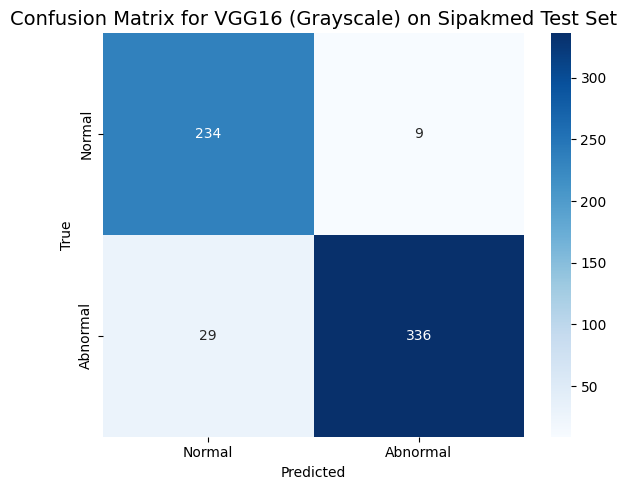


--- Evaluating: VGG16 (Grayscale) on Herlev Test Set ---
  - Loss: 0.2692, Accuracy: 0.8942
Classification Report:
              precision    recall  f1-score   support

      Normal     0.9783    0.6164    0.7563        73
    Abnormal     0.8772    0.9950    0.9324       201

    accuracy                         0.8942       274
   macro avg     0.9277    0.8057    0.8444       274
weighted avg     0.9041    0.8942    0.8855       274



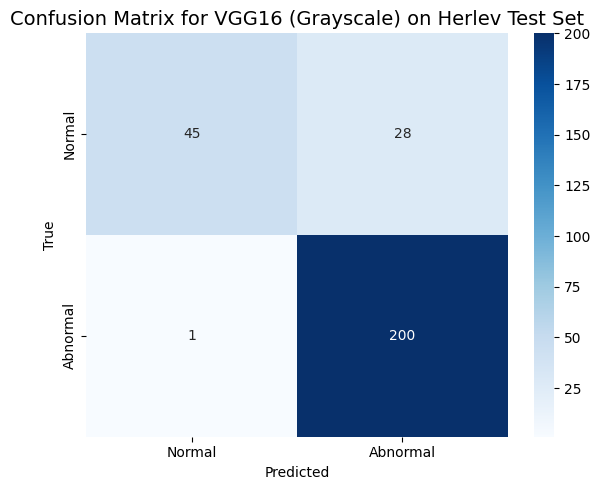


############################## FINAL RESULTS FOR: Xception (Grayscale) ##############################

--- Evaluating: Xception (Grayscale) on Sipakmed Test Set ---
  - Loss: 0.1084, Accuracy: 0.9671
Classification Report:
              precision    recall  f1-score   support

      Normal     0.9407    0.9794    0.9597       243
    Abnormal     0.9859    0.9589    0.9722       365

    accuracy                         0.9671       608
   macro avg     0.9633    0.9692    0.9659       608
weighted avg     0.9678    0.9671    0.9672       608



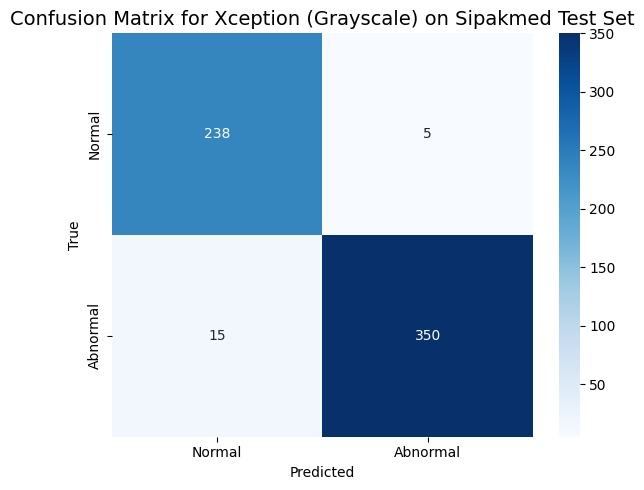


--- Evaluating: Xception (Grayscale) on Herlev Test Set ---
  - Loss: 0.3760, Accuracy: 0.8540
Classification Report:
              precision    recall  f1-score   support

      Normal     0.7797    0.6301    0.6970        73
    Abnormal     0.8744    0.9353    0.9038       201

    accuracy                         0.8540       274
   macro avg     0.8270    0.7827    0.8004       274
weighted avg     0.8492    0.8540    0.8487       274



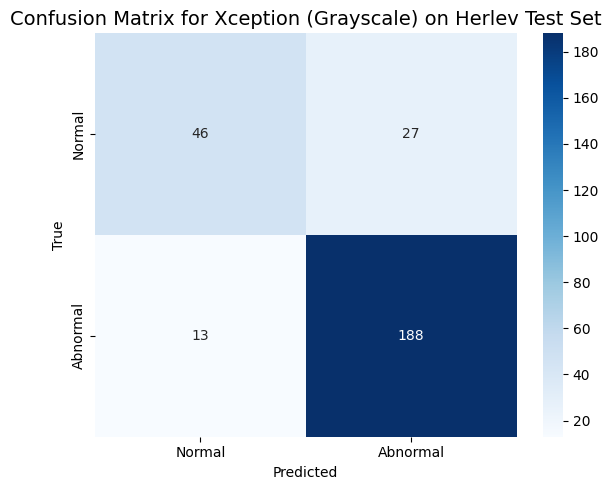


############################## FINAL RESULTS FOR: EfficientNetB2 (Grayscale) ##############################

--- Evaluating: EfficientNetB2 (Grayscale) on Sipakmed Test Set ---
  - Loss: 0.1483, Accuracy: 0.9490
Classification Report:
              precision    recall  f1-score   support

      Normal     0.9015    0.9794    0.9389       243
    Abnormal     0.9855    0.9288    0.9563       365

    accuracy                         0.9490       608
   macro avg     0.9435    0.9541    0.9476       608
weighted avg     0.9519    0.9490    0.9493       608



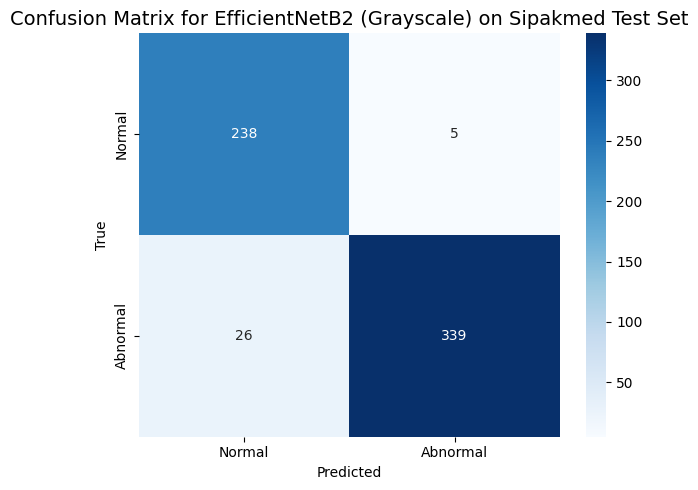


--- Evaluating: EfficientNetB2 (Grayscale) on Herlev Test Set ---
  - Loss: 0.2739, Accuracy: 0.8577
Classification Report:
              precision    recall  f1-score   support

      Normal     0.7500    0.6986    0.7234        73
    Abnormal     0.8932    0.9154    0.9042       201

    accuracy                         0.8577       274
   macro avg     0.8216    0.8070    0.8138       274
weighted avg     0.8551    0.8577    0.8560       274



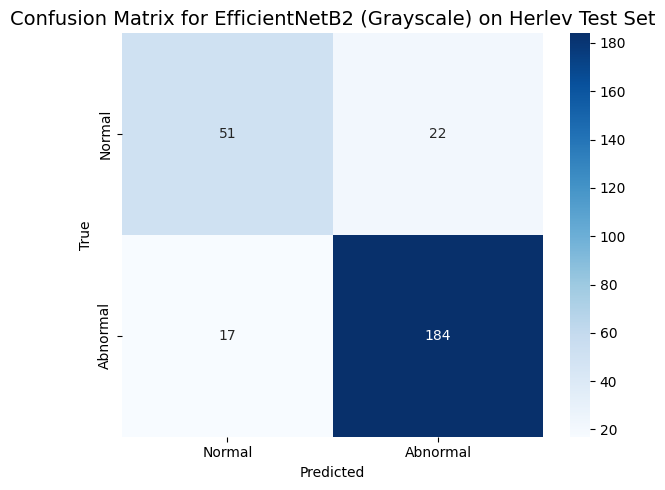


############################## FINAL RESULTS FOR: InceptionResNetV2 (Grayscale) ##############################

--- Evaluating: InceptionResNetV2 (Grayscale) on Sipakmed Test Set ---
  - Loss: 0.0708, Accuracy: 0.9753
Classification Report:
              precision    recall  f1-score   support

      Normal     0.9750    0.9630    0.9689       243
    Abnormal     0.9755    0.9836    0.9795       365

    accuracy                         0.9753       608
   macro avg     0.9753    0.9733    0.9742       608
weighted avg     0.9753    0.9753    0.9753       608



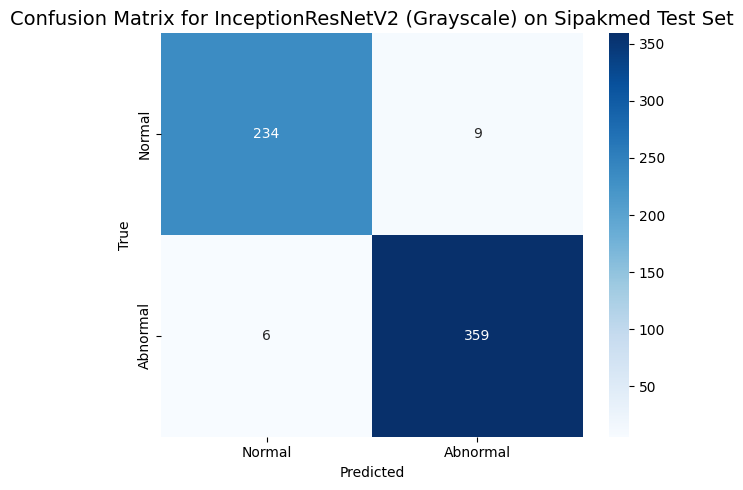


--- Evaluating: InceptionResNetV2 (Grayscale) on Herlev Test Set ---
  - Loss: 0.3577, Accuracy: 0.8686
Classification Report:
              precision    recall  f1-score   support

      Normal     0.7606    0.7397    0.7500        73
    Abnormal     0.9064    0.9154    0.9109       201

    accuracy                         0.8686       274
   macro avg     0.8335    0.8276    0.8304       274
weighted avg     0.8675    0.8686    0.8680       274



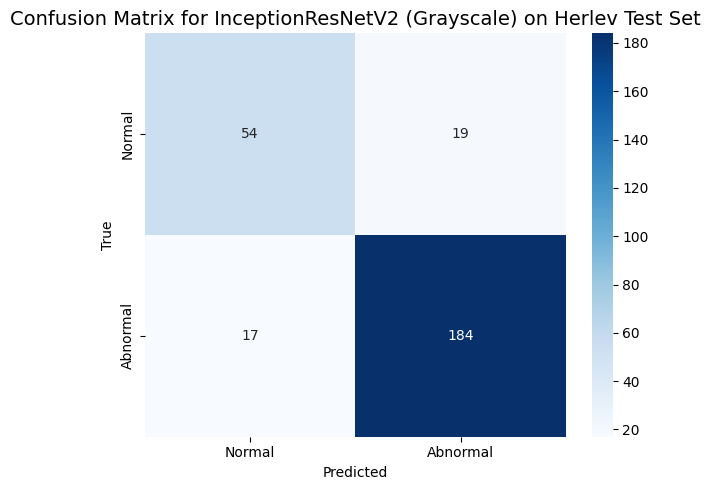


############################## FINAL RESULTS FOR: DenseNet201 (Grayscale) ##############################

--- Evaluating: DenseNet201 (Grayscale) on Sipakmed Test Set ---
  - Loss: 0.0856, Accuracy: 0.9737
Classification Report:
              precision    recall  f1-score   support

      Normal     0.9558    0.9794    0.9675       243
    Abnormal     0.9861    0.9699    0.9779       365

    accuracy                         0.9737       608
   macro avg     0.9709    0.9746    0.9727       608
weighted avg     0.9740    0.9737    0.9737       608



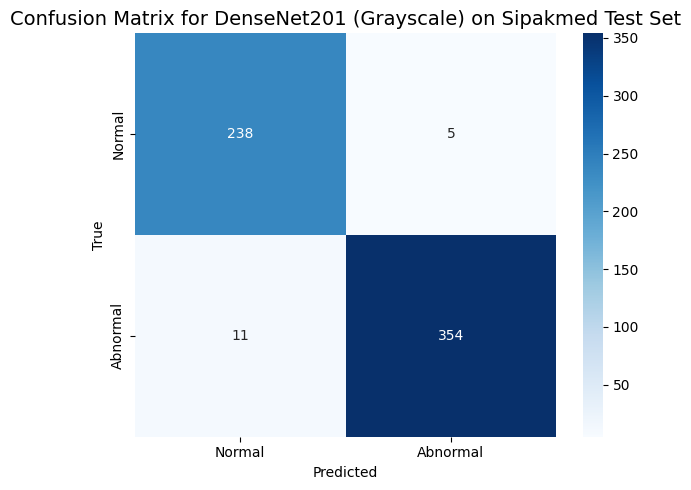


--- Evaluating: DenseNet201 (Grayscale) on Herlev Test Set ---
  - Loss: 0.3610, Accuracy: 0.8613
Classification Report:
              precision    recall  f1-score   support

      Normal     0.7536    0.7123    0.7324        73
    Abnormal     0.8976    0.9154    0.9064       201

    accuracy                         0.8613       274
   macro avg     0.8256    0.8139    0.8194       274
weighted avg     0.8592    0.8613    0.8600       274



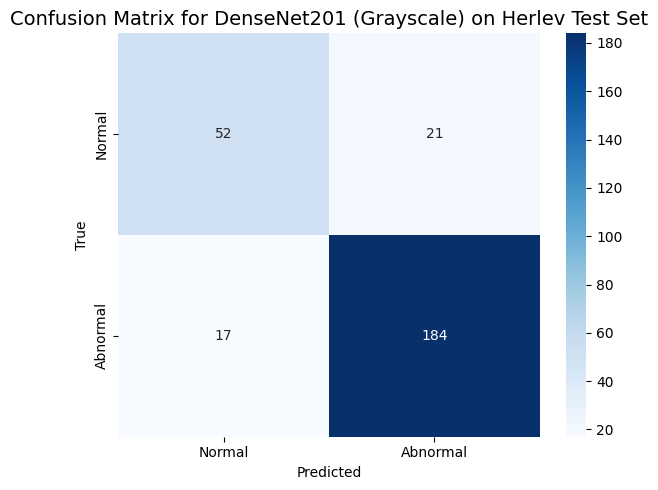


############################## FINAL RESULTS FOR: NASNetMobile (Grayscale) ##############################

--- Evaluating: NASNetMobile (Grayscale) on Sipakmed Test Set ---
  - Loss: 0.1113, Accuracy: 0.9655
Classification Report:
              precision    recall  f1-score   support

      Normal     0.9476    0.9671    0.9572       243
    Abnormal     0.9778    0.9644    0.9710       365

    accuracy                         0.9655       608
   macro avg     0.9627    0.9657    0.9641       608
weighted avg     0.9657    0.9655    0.9655       608



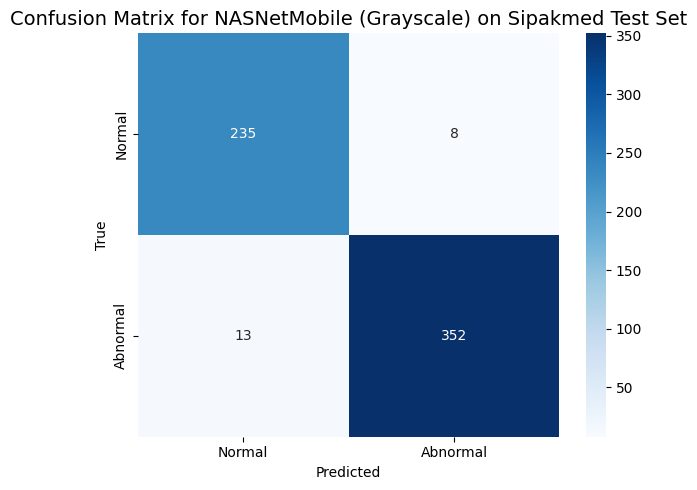


--- Evaluating: NASNetMobile (Grayscale) on Herlev Test Set ---
  - Loss: 0.4417, Accuracy: 0.8321
Classification Report:
              precision    recall  f1-score   support

      Normal     0.7143    0.6164    0.6618        73
    Abnormal     0.8673    0.9104    0.8883       201

    accuracy                         0.8321       274
   macro avg     0.7908    0.7634    0.7751       274
weighted avg     0.8265    0.8321    0.8280       274



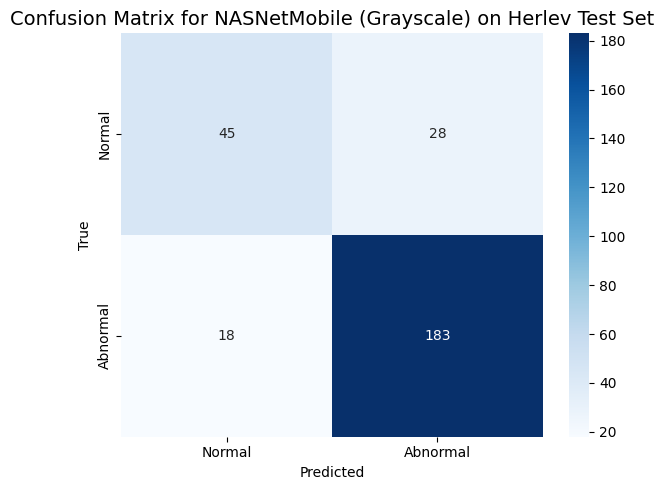


############################## FINAL RESULTS FOR: Averaging Ensemble (Grayscale) ##############################

--- Evaluating: Averaging Ensemble (Grayscale) on Sipakmed Test Set ---
  - Loss: 0.0800, Accuracy: 0.9786
Classification Report:
              precision    recall  f1-score   support

      Normal     0.9675    0.9794    0.9734       243
    Abnormal     0.9862    0.9781    0.9821       365

    accuracy                         0.9786       608
   macro avg     0.9768    0.9788    0.9778       608
weighted avg     0.9787    0.9786    0.9786       608



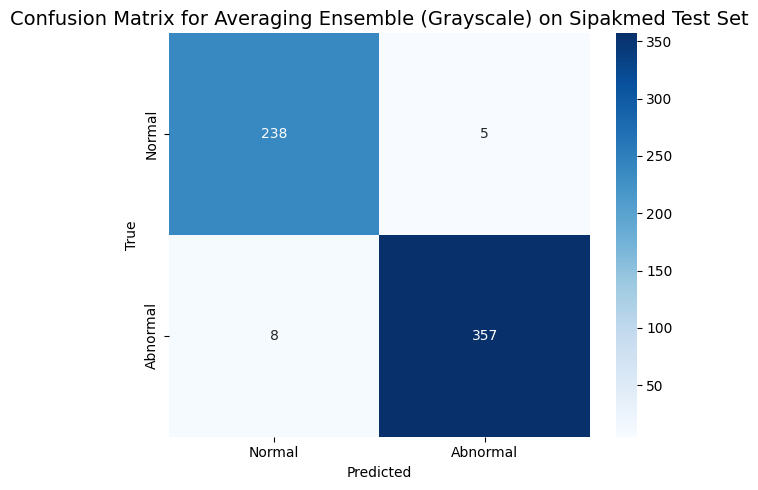


--- Evaluating: Averaging Ensemble (Grayscale) on Herlev Test Set ---
  - Loss: 0.2672, Accuracy: 0.8832
Classification Report:
              precision    recall  f1-score   support

      Normal     0.8868    0.6438    0.7460        73
    Abnormal     0.8824    0.9701    0.9242       201

    accuracy                         0.8832       274
   macro avg     0.8846    0.8070    0.8351       274
weighted avg     0.8835    0.8832    0.8767       274



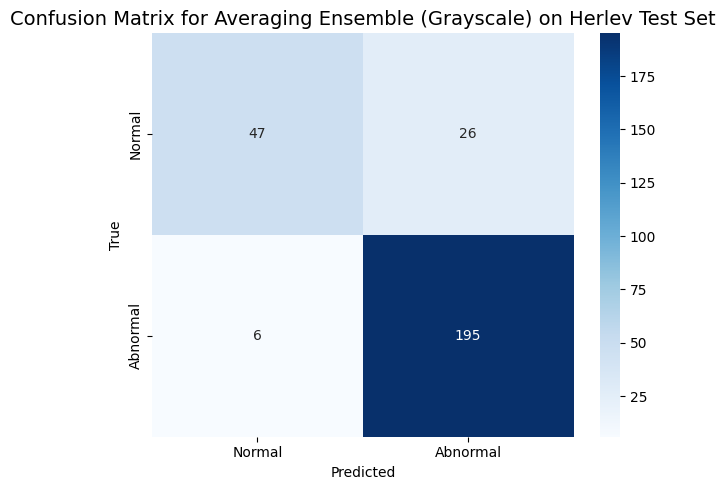


############################## FINAL RESULTS FOR: Stacking Ensemble (Grayscale) ##############################

--- Evaluating: Stacking Ensemble (Grayscale) on Sipakmed Test Set ---
  - Loss: 0.1333, Accuracy: 0.9655
Classification Report:
              precision    recall  f1-score   support

      Normal     0.9370    0.9794    0.9577       243
    Abnormal     0.9859    0.9562    0.9708       365

    accuracy                         0.9655       608
   macro avg     0.9614    0.9678    0.9643       608
weighted avg     0.9663    0.9655    0.9656       608



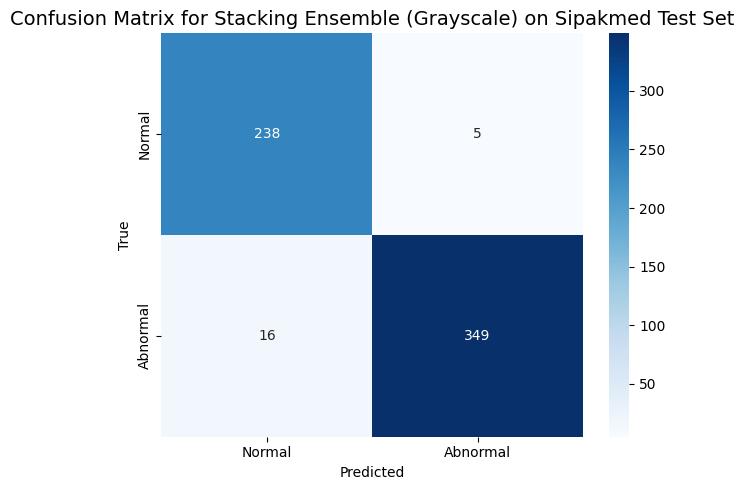


--- Evaluating: Stacking Ensemble (Grayscale) on Herlev Test Set ---
  - Loss: 0.3472, Accuracy: 0.8869
Classification Report:
              precision    recall  f1-score   support

      Normal     0.7692    0.8219    0.7947        73
    Abnormal     0.9337    0.9104    0.9219       201

    accuracy                         0.8869       274
   macro avg     0.8515    0.8662    0.8583       274
weighted avg     0.8899    0.8869    0.8880       274



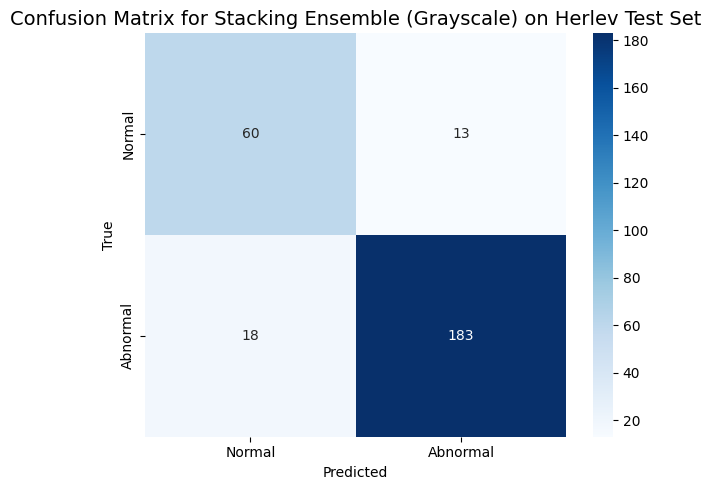


############################## FINAL RESULTS FOR: VGG16 (Color) ##############################

--- Evaluating: VGG16 (Color) on Sipakmed Test Set ---
  - Loss: 0.0521, Accuracy: 0.9836
Classification Report:
              precision    recall  f1-score   support

      Normal     0.9679    0.9918    0.9797       243
    Abnormal     0.9944    0.9781    0.9862       365

    accuracy                         0.9836       608
   macro avg     0.9812    0.9849    0.9829       608
weighted avg     0.9838    0.9836    0.9836       608



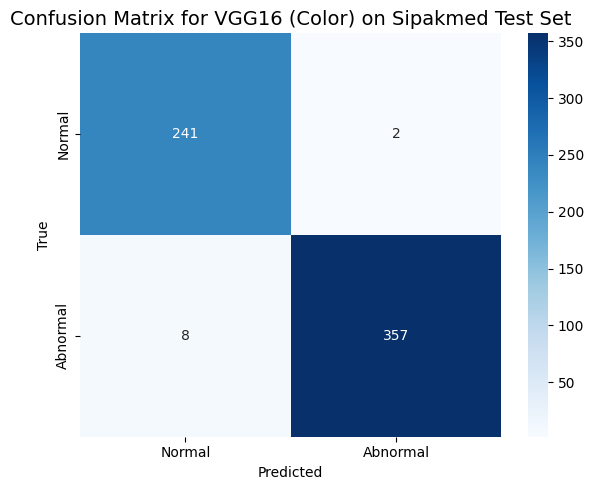


--- Evaluating: VGG16 (Color) on Herlev Test Set ---
  - Loss: 0.3776, Accuracy: 0.8212
Classification Report:
              precision    recall  f1-score   support

      Normal     0.6579    0.6849    0.6711        73
    Abnormal     0.8838    0.8706    0.8772       201

    accuracy                         0.8212       274
   macro avg     0.7709    0.7778    0.7742       274
weighted avg     0.8236    0.8212    0.8223       274



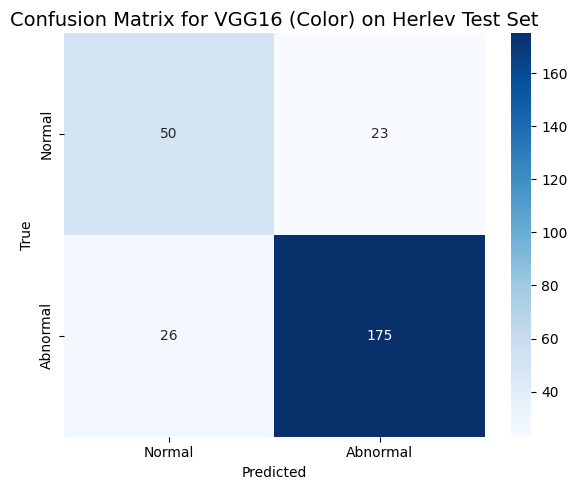


############################## FINAL RESULTS FOR: Xception (Color) ##############################

--- Evaluating: Xception (Color) on Sipakmed Test Set ---
  - Loss: 0.0361, Accuracy: 0.9868
Classification Report:
              precision    recall  f1-score   support

      Normal     0.9757    0.9918    0.9837       243
    Abnormal     0.9945    0.9836    0.9890       365

    accuracy                         0.9868       608
   macro avg     0.9851    0.9877    0.9863       608
weighted avg     0.9870    0.9868    0.9869       608



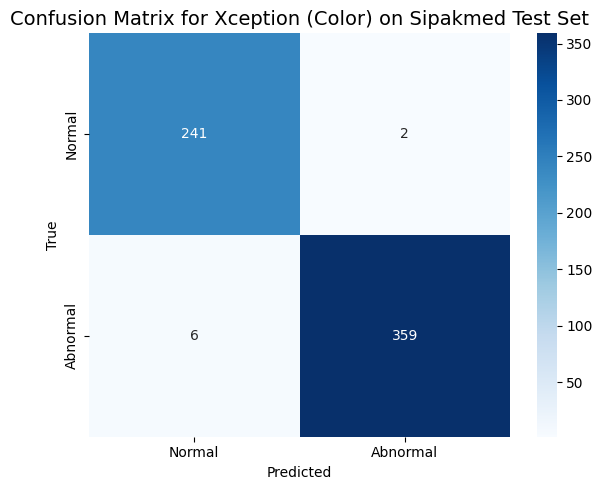


--- Evaluating: Xception (Color) on Herlev Test Set ---
  - Loss: 0.5590, Accuracy: 0.8431
Classification Report:
              precision    recall  f1-score   support

      Normal     0.6974    0.7260    0.7114        73
    Abnormal     0.8990    0.8856    0.8922       201

    accuracy                         0.8431       274
   macro avg     0.7982    0.8058    0.8018       274
weighted avg     0.8453    0.8431    0.8441       274



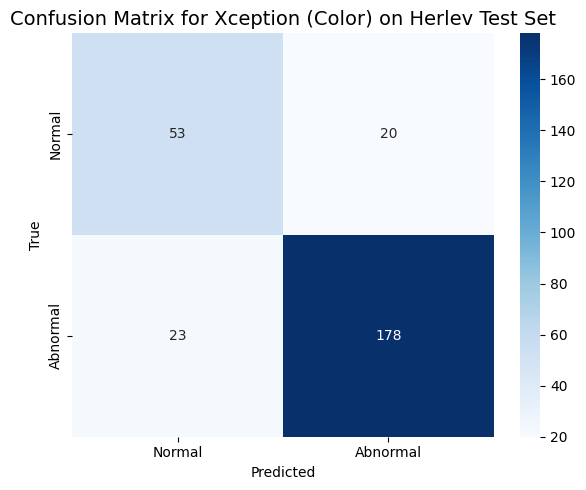


############################## FINAL RESULTS FOR: EfficientNetB2 (Color) ##############################

--- Evaluating: EfficientNetB2 (Color) on Sipakmed Test Set ---
  - Loss: 0.0766, Accuracy: 0.9770
Classification Report:
              precision    recall  f1-score   support

      Normal     0.9673    0.9753    0.9713       243
    Abnormal     0.9835    0.9781    0.9808       365

    accuracy                         0.9770       608
   macro avg     0.9754    0.9767    0.9760       608
weighted avg     0.9770    0.9770    0.9770       608



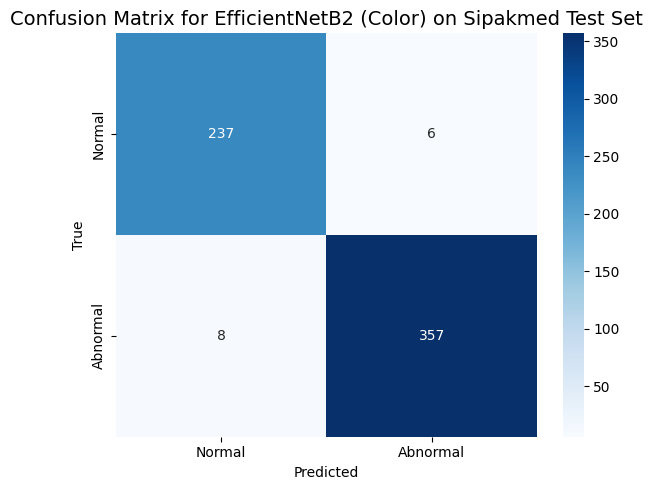


--- Evaluating: EfficientNetB2 (Color) on Herlev Test Set ---
  - Loss: 0.4339, Accuracy: 0.8869
Classification Report:
              precision    recall  f1-score   support

      Normal     0.8281    0.7260    0.7737        73
    Abnormal     0.9048    0.9453    0.9246       201

    accuracy                         0.8869       274
   macro avg     0.8664    0.8357    0.8491       274
weighted avg     0.8843    0.8869    0.8844       274



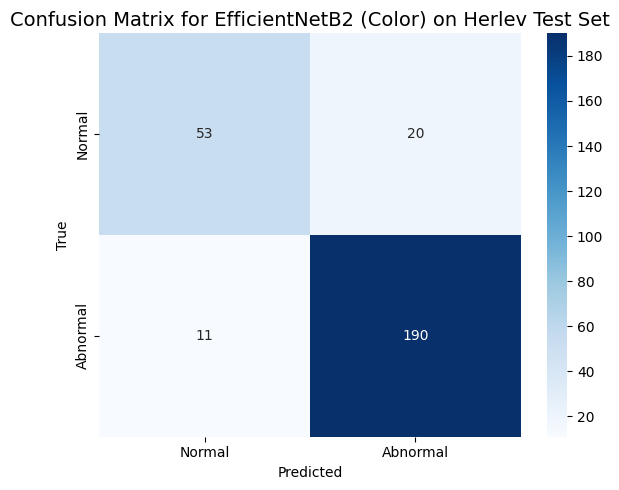


############################## FINAL RESULTS FOR: InceptionResNetV2 (Color) ##############################

--- Evaluating: InceptionResNetV2 (Color) on Sipakmed Test Set ---
  - Loss: 0.0503, Accuracy: 0.9819
Classification Report:
              precision    recall  f1-score   support

      Normal     0.9715    0.9835    0.9775       243
    Abnormal     0.9890    0.9808    0.9849       365

    accuracy                         0.9819       608
   macro avg     0.9802    0.9822    0.9812       608
weighted avg     0.9820    0.9819    0.9819       608



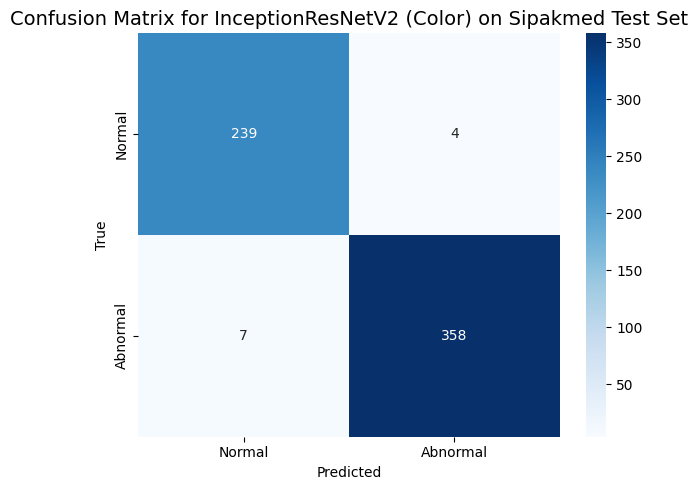


--- Evaluating: InceptionResNetV2 (Color) on Herlev Test Set ---
  - Loss: 0.4738, Accuracy: 0.8869
Classification Report:
              precision    recall  f1-score   support

      Normal     0.8621    0.6849    0.7634        73
    Abnormal     0.8935    0.9602    0.9257       201

    accuracy                         0.8869       274
   macro avg     0.8778    0.8226    0.8445       274
weighted avg     0.8851    0.8869    0.8824       274



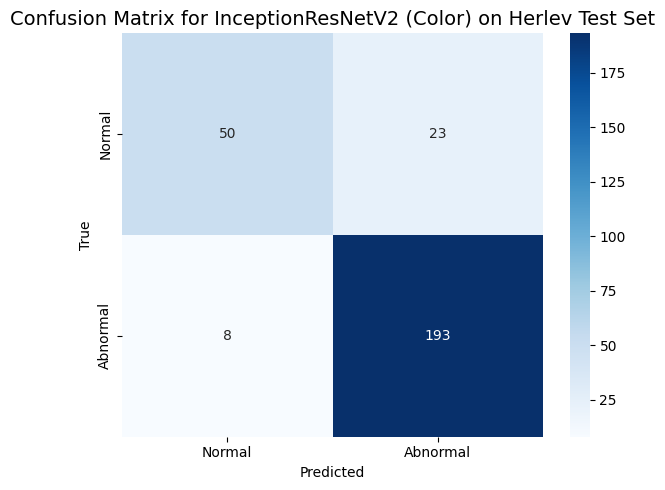


############################## FINAL RESULTS FOR: DenseNet201 (Color) ##############################

--- Evaluating: DenseNet201 (Color) on Sipakmed Test Set ---
  - Loss: 0.0756, Accuracy: 0.9770
Classification Report:
              precision    recall  f1-score   support

      Normal     0.9673    0.9753    0.9713       243
    Abnormal     0.9835    0.9781    0.9808       365

    accuracy                         0.9770       608
   macro avg     0.9754    0.9767    0.9760       608
weighted avg     0.9770    0.9770    0.9770       608



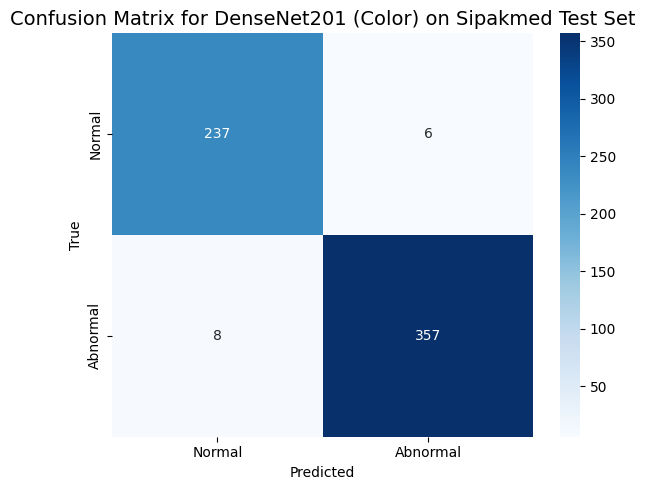


--- Evaluating: DenseNet201 (Color) on Herlev Test Set ---
  - Loss: 0.5260, Accuracy: 0.8650
Classification Report:
              precision    recall  f1-score   support

      Normal     0.8214    0.6301    0.7132        73
    Abnormal     0.8761    0.9502    0.9117       201

    accuracy                         0.8650       274
   macro avg     0.8488    0.7902    0.8124       274
weighted avg     0.8616    0.8650    0.8588       274



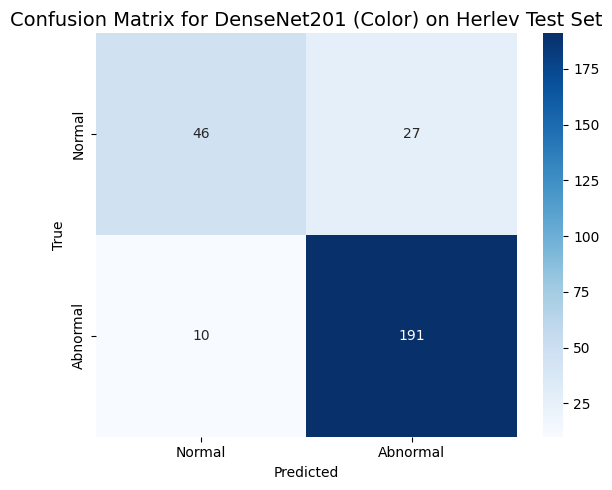


############################## FINAL RESULTS FOR: NASNetMobile (Color) ##############################

--- Evaluating: NASNetMobile (Color) on Sipakmed Test Set ---
  - Loss: 0.1173, Accuracy: 0.9638
Classification Report:
              precision    recall  f1-score   support

      Normal     0.9911    0.9177    0.9530       243
    Abnormal     0.9478    0.9945    0.9706       365

    accuracy                         0.9638       608
   macro avg     0.9694    0.9561    0.9618       608
weighted avg     0.9651    0.9638    0.9636       608



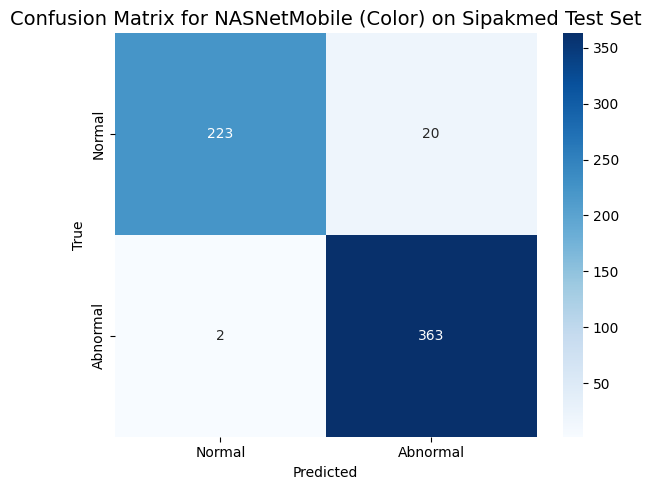


--- Evaluating: NASNetMobile (Color) on Herlev Test Set ---
  - Loss: 0.4838, Accuracy: 0.8431
Classification Report:
              precision    recall  f1-score   support

      Normal     0.7500    0.6164    0.6767        73
    Abnormal     0.8692    0.9254    0.8964       201

    accuracy                         0.8431       274
   macro avg     0.8096    0.7709    0.7865       274
weighted avg     0.8374    0.8431    0.8379       274



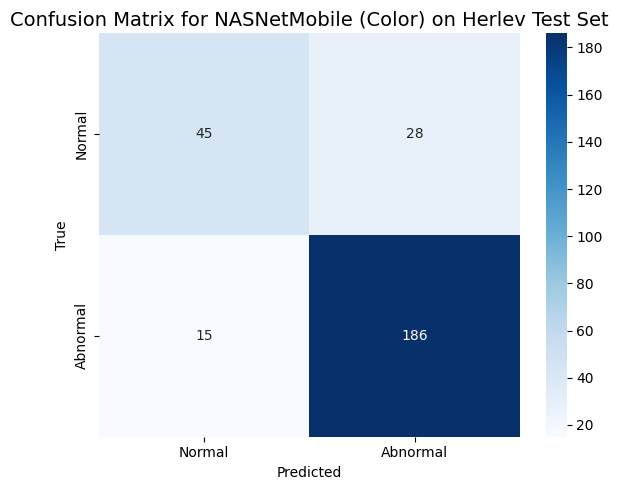


############################## FINAL RESULTS FOR: Averaging Ensemble (Color) ##############################

--- Evaluating: Averaging Ensemble (Color) on Sipakmed Test Set ---
  - Loss: 0.0366, Accuracy: 0.9901
Classification Report:
              precision    recall  f1-score   support

      Normal     0.9877    0.9877    0.9877       243
    Abnormal     0.9918    0.9918    0.9918       365

    accuracy                         0.9901       608
   macro avg     0.9897    0.9897    0.9897       608
weighted avg     0.9901    0.9901    0.9901       608



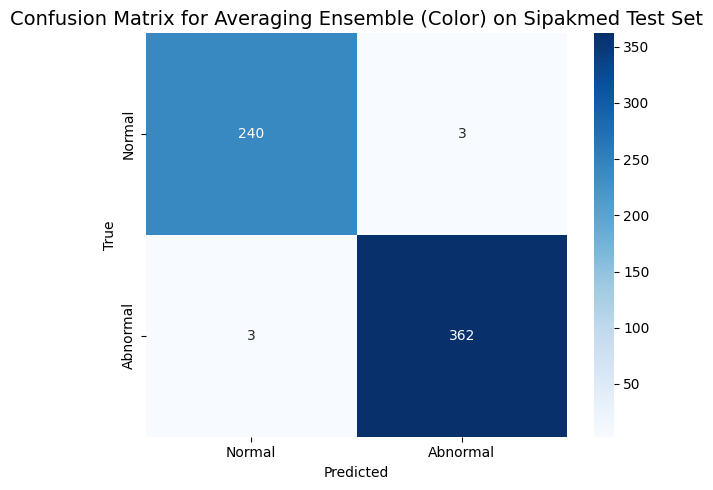


--- Evaluating: Averaging Ensemble (Color) on Herlev Test Set ---
  - Loss: 0.3156, Accuracy: 0.8869
Classification Report:
              precision    recall  f1-score   support

      Normal     0.8750    0.6712    0.7597        73
    Abnormal     0.8899    0.9652    0.9260       201

    accuracy                         0.8869       274
   macro avg     0.8825    0.8182    0.8429       274
weighted avg     0.8859    0.8869    0.8817       274



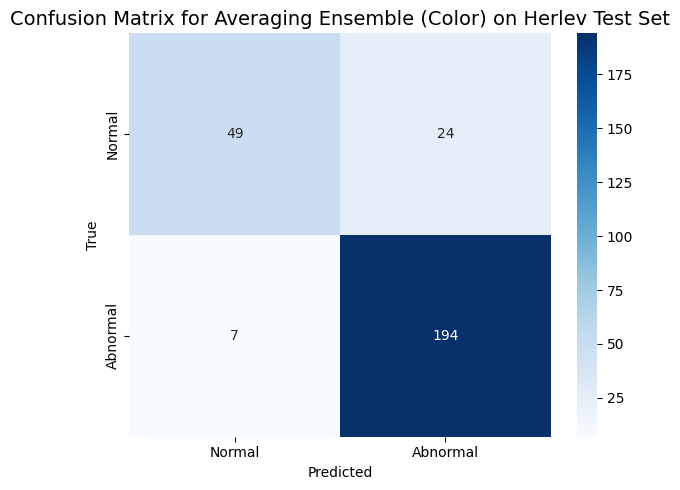


############################## FINAL RESULTS FOR: Stacking Ensemble (Color) ##############################

--- Evaluating: Stacking Ensemble (Color) on Sipakmed Test Set ---
  - Loss: 0.0247, Accuracy: 0.9901
Classification Report:
              precision    recall  f1-score   support

      Normal     0.9798    0.9959    0.9878       243
    Abnormal     0.9972    0.9863    0.9917       365

    accuracy                         0.9901       608
   macro avg     0.9885    0.9911    0.9897       608
weighted avg     0.9902    0.9901    0.9901       608



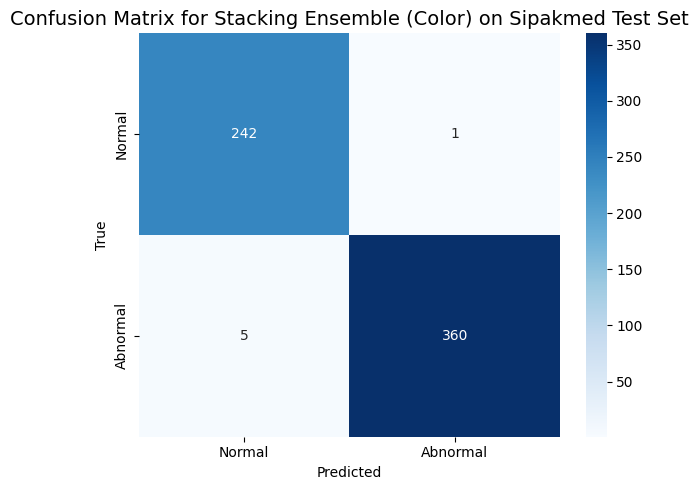


--- Evaluating: Stacking Ensemble (Color) on Herlev Test Set ---
  - Loss: 0.6826, Accuracy: 0.8686
Classification Report:
              precision    recall  f1-score   support

      Normal     0.7606    0.7397    0.7500        73
    Abnormal     0.9064    0.9154    0.9109       201

    accuracy                         0.8686       274
   macro avg     0.8335    0.8276    0.8304       274
weighted avg     0.8675    0.8686    0.8680       274



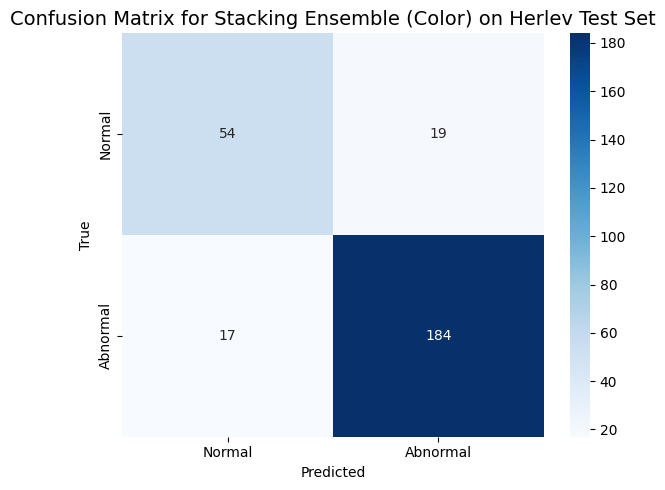

In [10]:
# ==============================================================================
# COMPREHENSIVE FINAL EVALUATION
# ==============================================================================


def evaluate_model(model_path, test_ds, model_name):
    """
    Loads a saved model and evaluates it on a given test dataset, printing a
    full report and displaying a confusion matrix.
    """

    print(f"\n--- Evaluating: {model_name} ---")

    model = load_model(str(model_path), compile=False)
    model.compile(loss=BinaryCrossentropy(), metrics=['accuracy'])
    loss, acc = model.evaluate(test_ds, verbose=0)
    print(f"  - Loss: {loss:.4f}, Accuracy: {acc:.4f}")

    y_true = np.concatenate([y for _, y in test_ds], axis=0).flatten()
    y_pred_proba = model.predict(test_ds, verbose=0)
    y_pred = (y_pred_proba > 0.5).astype(int).flatten()

    print("Classification Report:")
    print(classification_report(y_true, y_pred, target_names=CLASS_NAMES, digits=4))

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
    plt.title(f'Confusion Matrix for {model_name}', fontsize=14)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()
    plt.show()

# test daatasets
all_test_sets = {}
all_models_config_eval = [
    {"name": "VGG16", "preproc_fn": tf.keras.applications.vgg16.preprocess_input},
    {"name": "Xception", "preproc_fn": tf.keras.applications.xception.preprocess_input},
    {"name": "EfficientNetB2", "preproc_fn": tf.keras.applications.efficientnet.preprocess_input},
    {"name": "InceptionResNetV2", "preproc_fn": tf.keras.applications.inception_resnet_v2.preprocess_input},
    {"name": "DenseNet201", "preproc_fn": tf.keras.applications.densenet.preprocess_input},
    {"name": "NASNetMobile", "preproc_fn": tf.keras.applications.nasnet.preprocess_input}
]

for variant in ['Grayscale', 'Color']:
    is_gray, use_color = (variant == 'Grayscale'), (variant == 'Color')
    for config in all_models_config_eval:
        name = f"{config['name']}_{variant}"
        all_test_sets[f"{name}_Sipakmed"] = create_dataset(sipakmed_test_df, is_grayscale=is_gray, use_color_pp=use_color, preprocess_fn=config['preproc_fn'])
        all_test_sets[f"{name}_Herlev"] = create_dataset(herlev_test_df, is_grayscale=is_gray, use_color_pp=use_color, preprocess_fn=config['preproc_fn'])
    all_test_sets[f"Ensemble_{variant}_Sipakmed"] = create_dataset(sipakmed_test_df, is_grayscale=is_gray, use_color_pp=use_color)
    all_test_sets[f"Ensemble_{variant}_Herlev"] = create_dataset(herlev_test_df, is_grayscale=is_gray, use_color_pp=use_color)

# structured list of evaluation tasks
evaluation_tasks = []
for variant in ['Grayscale', 'Color']:
    for config in all_models_config_eval:
        evaluation_tasks.append({
            "name": f"{config['name']} ({variant})", "path": MODELS_SAVE_PATH / f"{config['name']}_{variant}_best_finetuned.keras",
            "sip_ds": all_test_sets[f"{config['name']}_{variant}_Sipakmed"], "her_ds": all_test_sets[f"{config['name']}_{variant}_Herlev"]
        })
    evaluation_tasks.append({"name": f"Averaging Ensemble ({variant})", "path": MODELS_SAVE_PATH / f"Averaging_Ensemble_{variant}_best.keras", "sip_ds": all_test_sets[f"Ensemble_{variant}_Sipakmed"], "her_ds": all_test_sets[f"Ensemble_{variant}_Herlev"]})
    evaluation_tasks.append({"name": f"Stacking Ensemble ({variant})", "path": MODELS_SAVE_PATH / f"Stacking_Ensemble_{variant}_best.keras", "sip_ds": all_test_sets[f"Ensemble_{variant}_Sipakmed"], "her_ds": all_test_sets[f"Ensemble_{variant}_Herlev"]})

# eval loop
for task in evaluation_tasks:
    if not task['path'].exists():
        print(f"\nSKIPPING EVALUATION: Model file not found at '{task['path']}'")
        continue
    print("\n" + "#"*30 + f" FINAL RESULTS FOR: {task['name']} " + "#"*30)
    evaluate_model(task['path'], task['sip_ds'], f"{task['name']} on Sipakmed Test Set")
    evaluate_model(task['path'], task['her_ds'], f"{task['name']} on Herlev Test Set")
# ==============================================================================